# Modelo de Identificação de Parcialidade em Notícias Jornalísticas


In [2]:
# coding: utf-8

"""
Mapeamento dos Arquivos
"""

BASE = '/content/drive/MyDrive/Colab Notebooks/base_analytics.csv'
BASE_FINAL = '/content/drive/MyDrive/Colab Notebooks/base_analytics_final.csv'

MODEL_GENERATOR = True
EPOCHS = 10
BATCH_SIZE = 1000

MODEL_SENTI = '/content/drive/MyDrive/Colab Notebooks/model_bidirecional_senti.h5'
HISTORY_RESULTS_SENTI = '/content/drive/MyDrive/Colab Notebooks/history_results_bidirecional_senti.csv'

MODEL_NAIVE = '/content/drive/MyDrive/Colab Notebooks/model_bidirecional_naive.h5'
HISTORY_RESULTS_NAIVE = '/content/drive/MyDrive/Colab Notebooks/history_results_bidirecional_naive.csv'

WORD2VEC_S50 = '/content/drive/MyDrive/Colab Notebooks/word2vec_s50.txt'



### Carregamento do WordEmbedding

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from gensim.models import KeyedVectors

# Carregar o Word Embedding Pré-Treinado
Word2Vec = KeyedVectors.load_word2vec_format(WORD2VEC_S50)

MAX_NB_WORDS = len(Word2Vec.vocab)
EMBEDDING_DIM = 50

print("\nTamanhos dos vocabulários:\n -> Word2Vec - " + str(MAX_NB_WORDS))



Tamanhos dos vocabulários:
 -> Word2Vec - 929606


### Preparação das Bases


*   Base de Treinamento Senti Strength
*   Base de Treinamento Naive Bayes
*   Base de Teste



In [5]:
import re
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stopWords = set(stopwords.words('portuguese'))

"""
É descartado a palavra Não das StopWords pelo seu impacto no sentido da frase.
"""
stopWords.discard('não')

base = pd.read_csv(BASE, sep=';', index_col=None,
    names=[
        'article',
        'title',
        'type',
        'typeNaive',
        'typeSenti',
        'positivo',
        'negativo',
        'neutro',
        'link',
        'origem',
        'id',
        'length',
        'count_neutral_words',
        'lenght_caract'
    ]
)


def clean_text(text):
    """
    Realiza a preparação do texto para ser utilizada
    Removendo pontuações, links, aspas e tornando tadas as letras em minúsculo
    Removendo as StopWords
    """

    text = re.sub(r'[^\w\s$]|http\S+', '', text).lower()
    text = text.replace(r'/[\'"]+/g', '')
    text = ' '.join(word for word in text.split() if word not in stopWords)
    
    return text

base['article_clean'] = base['article'].apply(clean_text)

base['article_len'] = base['article_clean'].apply(lambda x : len(x))

MAX_LEN = int(base['article_len'].quantile(.75))
#75% do dataset pelo menos tem no maximo esse valor de tamanho
print("\nTamanhos Máximo das Notícias da Base:\n -> 75% do dataset - " + str(MAX_LEN))

base['article_tokens'] = base['article_clean'].apply(lambda text : word_tokenize(text.strip()) )

def create_x(tokens, embedding_model):
    """
    Buscar a localização dos tokens dentro do Word2Vec
    """

    list_x = []
    for token in tokens:
        if(token):
            if(token in embedding_model.vocab):
                list_x.append(embedding_model.vocab[token].index)
        
    return list_x

base['article_tokens_word2vec'] = base['article_tokens'].apply(lambda text : create_x(text, Word2Vec))

base.head(2)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.

Tamanhos Máximo das Notícias da Base:
 -> 75% do dataset - 2396


,article,title,type,typeNaive,typeSenti,positivo,negativo,neutro,link,origem,id,length,count_neutral_words,lenght_caract,article_clean,article_len,article_tokens,article_tokens_word2vec
0,"Doria chama gestão da pandemia de 'descaso', e...","Doria chama gestão da pandemia de 'descaso', e...",NaN,partial,partial,2,-3,-1,https://diariodonordeste.verdesmares.com.br/po...,Diário do Nordeste,1,25,4,2449,doria chama gestão pandemia descaso queiroga d...,1907,"[doria, chama, gestão, pandemia, descaso, quei...","[18328, 2200, 658, 33346, 28604, 54972, 222, 1..."
1,Câmara aprova suspensão da carteira do motoris...,Câmara aprova suspensão da carteira do motoris...,NaN,partial,partial,3,-3,-1,https://g1.globo.com/politica/noticia/2021/09/...,G1 Ceará,2,24,4,3435,câmara aprova suspensão carteira motorista pub...,2564,"[câmara, aprova, suspensão, carteira, motorist...","[444, 7227, 2480, 3965, 2671, 5488, 14052, 162..."


In [6]:
training = base[~base['type'].isin(['impartial', 'partial'])]
test = base[base['type'].isin(['impartial', 'partial'])]

lenBase = len(base)
lenTraining = len(training)
lenTest = len(test)

labels = base['type'].value_counts().axes[0].tolist()

counts_labels_human_type = test['type'].value_counts()
counts_labels_naive_type = training['typeNaive'].value_counts()
counts_labels_senti_type = training['typeSenti'].value_counts()

dataFrameAnalyticsBase = pd.DataFrame(columns=['base', 'length', 'impartial', 'partial'])

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Total",
    'length': lenBase,
    labels[0]: '-',
    labels[1]: '-'
}, ignore_index=True)

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Training Naive Bayes",
    'length': lenTraining,
    labels[0]: counts_labels_naive_type[0],
    labels[1]: counts_labels_naive_type[1]
}, ignore_index=True)

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Training Senti Strength",
    'length': lenTraining,
    labels[0]: counts_labels_senti_type[0],
    labels[1]: counts_labels_senti_type[1]
}, ignore_index=True)

dataFrameAnalyticsBase = dataFrameAnalyticsBase.append({
    'base': "Base Test",
    'length': lenTest,
    labels[0]: counts_labels_human_type[0],
    labels[1]: counts_labels_human_type[1]
}, ignore_index=True)

dataFrameAnalyticsBase



,base,length,impartial,partial
0,Base Total,18175,-,-
1,Base Training Naive Bayes,17875,10102,7773
2,Base Training Senti Strength,17875,9536,8339
3,Base Test,300,232,68


### Preparação do MODELO

In [7]:
import numpy as np

def create_embedding_matrix(vocab, n_words, emb_size):
    """
    Transformar o Word2Vec em uma matrix
    """

    pret_embedding = {}

    """
    Retorna uma nova matriz de forma e tipo fornecidos, preenchida com zeros.
    n_words - Tamanho da matriz
    emb_size - Comprimento de zeros
    """
    embedding_matrix = np.zeros((n_words, emb_size))
    count = 0

    """
    Dicionário com todos os ids e palavras do embedding pré-treinado
    Chave como a palavra buscada e Value como a chave de localização no Word2Vec
    """
    for index, word in enumerate(vocab.index2word):
        pret_embedding[word] = index

    # Construindo a embedding_matrix do embedding pré-treinado
    for item in pret_embedding.items():
        if item[1] < n_words:
            count += 1
            embedding_vector = vocab.word_vec(item[0])
            
            if embedding_vector is not None:
                embedding_matrix[item[1]] = embedding_vector
    
    return embedding_matrix

if (MODEL_GENERATOR):
    embedding_matrix = create_embedding_matrix(Word2Vec, MAX_NB_WORDS, EMBEDDING_DIM)
    print(embedding_matrix.shape)


(929606, 50)


In [8]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

if (MODEL_GENERATOR):
    # pad_sequences é usado para garantir que todas as sequências em uma lista tenham o mesmo comprimento.
    # o comprimento será o maior valor entre os 75% da base
    X = pad_sequences(
        maxlen=MAX_LEN,
        sequences=training['article_tokens_word2vec'],
        value=0,
        padding='post',
        truncating='post'
    )

    # pandas get_dummies transforma em valor binário
    # pd.get_dummies([impartial, partial, impartial])
    # result [ [1,0], [0,1], [1,0] ]
    Y_naive = pd.get_dummies(training['typeNaive']).values
    Y_senti = pd.get_dummies(training['typeSenti']).values

    print(X.shape, Y_naive.shape, Y_senti.shape)


(17875, 2396) (17875, 2) (17875, 2)


In [9]:
from sklearn.model_selection import train_test_split

if (MODEL_GENERATOR):
    # train_test_split - Divide arrays ou matrizes em arrays menores, aleatórios e com subconjuntos de teste
    # test_size=0.20 - Reservado 20% para teste
    X_train_naive, X_test_naive, Y_train_naive, Y_test_naive = train_test_split(X,Y_naive, test_size = 0.20, random_state = 42, stratify=Y_naive)

    X_train_senti, X_test_senti, Y_train_senti, Y_test_senti = train_test_split(X,Y_senti, test_size = 0.20, random_state = 42, stratify=Y_senti)
    
    print(X_train_naive.shape, Y_train_naive.shape)
    print(X_test_naive.shape, Y_test_naive.shape)

    print(X_train_senti.shape, Y_train_senti.shape)
    print(X_test_senti.shape, Y_test_senti.shape)
    

(14300, 2396) (14300, 2)
(3575, 2396) (3575, 2)
(14300, 2396) (14300, 2)
(3575, 2396) (3575, 2)


In [10]:
from keras.layers import Dense, LSTM, SpatialDropout1D, Bidirectional, Dropout
from keras.layers.embeddings import Embedding
from keras.models import Sequential

if (MODEL_GENERATOR):
    num_labels_naive = Y_naive.shape[1]

    model_naive = Sequential()
    model_naive.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], weights=[embedding_matrix]))
    model_naive.add(SpatialDropout1D(0.2))
    model_naive.add(Bidirectional(LSTM(64)))
    model_naive.add(Dropout(0.1))
    model_naive.add(Dense(num_labels_naive, activation='softmax'))
    model_naive.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_naive.summary()
    

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2396, 50)          46480300  
                                                                 
 spatial_dropout1d (SpatialD  (None, 2396, 50)         0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 128)              58880     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 46,539,438
Trainable params: 46,539,438
No

In [11]:
if (MODEL_GENERATOR):
    num_labels_senti = Y_senti.shape[1]

    model_senti = Sequential()
    model_senti.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1], weights=[embedding_matrix]))
    model_senti.add(SpatialDropout1D(0.2))
    model_senti.add(Bidirectional(LSTM(64)))
    model_senti.add(Dropout(0.1))
    model_senti.add(Dense(num_labels_senti, activation='softmax'))
    model_senti.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model_senti.summary()
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2396, 50)          46480300  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 2396, 50)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 46,539,438
Trainable params: 46,539,438


In [12]:
from pathlib import Path

if (MODEL_GENERATOR):
    if Path(MODEL_NAIVE).is_file():
        model_naive.load_weights(MODEL_NAIVE)
    
    if Path(MODEL_SENTI).is_file():
        model_senti.load_weights(MODEL_SENTI)
        

In [13]:
from keras.callbacks import EarlyStopping, CSVLogger

if (MODEL_GENERATOR):
    model_naive.fit(
        X_train_naive,
        Y_train_naive,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),
            CSVLogger(HISTORY_RESULTS_NAIVE, separator=';', append=True)
        ])

    accr = model_naive.evaluate(X_test_naive, Y_test_naive)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    model_naive.save(MODEL_NAIVE)

Epoch 1/10
13/13 [==============================] - 347s 25s/step - loss: 0.6797 - accuracy: 0.5611 - val_loss: 0.6756 - val_accuracy: 0.5615
Epoch 2/10
13/13 [==============================] - 422s 29s/step - loss: 0.6617 - accuracy: 0.5997 - val_loss: 0.6595 - val_accuracy: 0.5888
Epoch 3/10
13/13 [==============================] - 452s 36s/step - loss: 0.6363 - accuracy: 0.6305 - val_loss: 0.6364 - val_accuracy: 0.6238
Epoch 4/10
13/13 [==============================] - 373s 29s/step - loss: 0.6079 - accuracy: 0.6567 - val_loss: 0.6232 - val_accuracy: 0.6259
Epoch 5/10
13/13 [==============================] - 402s 30s/step - loss: 0.5765 - accuracy: 0.6905 - val_loss: 0.6143 - val_accuracy: 0.6601
Epoch 6/10
13/13 [==============================] - 391s 31s/step - loss: 0.5382 - accuracy: 0.7197 - val_loss: 0.5449 - val_accuracy: 0.7280
Epoch 7/10
13/13 [==============================] - 392s 30s/step - loss: 0.4618 - accuracy: 0.7850 - val_loss: 0.5757 - val_accuracy: 0.7657
Epoch 

In [14]:
if (MODEL_GENERATOR):
    model_senti.fit(
        X_train_senti,
        Y_train_senti,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),
            CSVLogger(HISTORY_RESULTS_SENTI, separator=';', append=True)
        ])

    accr = model_senti.evaluate(X_test_senti, Y_test_senti)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

    model_senti.save(MODEL_SENTI)

Epoch 1/10
13/13 [==============================] - 427s 32s/step - loss: 0.6917 - accuracy: 0.5333 - val_loss: 0.6848 - val_accuracy: 0.5706
Epoch 2/10
13/13 [==============================] - 514s 40s/step - loss: 0.6779 - accuracy: 0.5781 - val_loss: 0.6713 - val_accuracy: 0.5825
Epoch 3/10
13/13 [==============================] - 399s 30s/step - loss: 0.6577 - accuracy: 0.6010 - val_loss: 0.6483 - val_accuracy: 0.5993
Epoch 4/10
13/13 [==============================] - 428s 34s/step - loss: 0.6363 - accuracy: 0.6267 - val_loss: 0.6384 - val_accuracy: 0.6196
Epoch 5/10
13/13 [==============================] - 433s 32s/step - loss: 0.6027 - accuracy: 0.6792 - val_loss: 0.6453 - val_accuracy: 0.6273
Epoch 6/10
13/13 [==============================] - 430s 32s/step - loss: 0.5842 - accuracy: 0.6997 - val_loss: 0.6798 - val_accuracy: 0.6147
Epoch 7/10
13/13 [==============================] - 539s 41s/step - loss: 0.6081 - accuracy: 0.6796 - val_loss: 0.6234 - val_accuracy: 0.6706
Epoch 

### Analise Historico do Modelo


Epocas do Modelo - 10


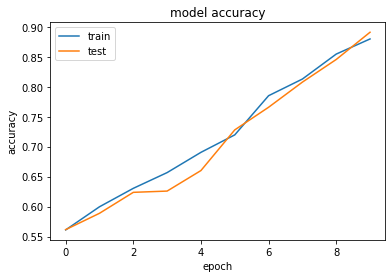

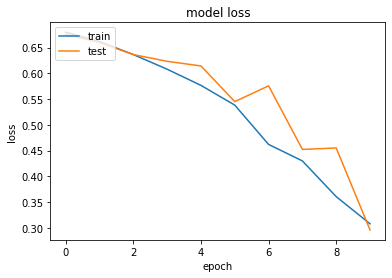

In [15]:
import matplotlib.pyplot as plt

history_results = pd.read_csv(HISTORY_RESULTS_NAIVE, sep=';')
print("\nEpocas do Modelo - " + str(len(history_results['accuracy'])) )

# summarize history for accuracy
plt.plot(history_results['accuracy'])
plt.plot(history_results['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history_results['loss'])
plt.plot(history_results['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Exibir Acuracia dos Modelos já treinados

In [19]:
from keras.models import load_model

mapModels = [
    {
        'model': MODEL_NAIVE,
        'history': HISTORY_RESULTS_NAIVE
     },
    {
        'model': MODEL_SENTI,
        'history': HISTORY_RESULTS_SENTI
     }
]

def predictModel(text, labels, max_len, model):
    """
    Prepara um texto único e analizá-lo pelo o Modelo gerado
    """
    
    X = pad_sequences(
        maxlen=max_len,
        sequences=[text],
        value=0,
        padding='post',
        truncating='post'
    )
    
    pred = model.predict(X)

    return labels[np.argmax(pred)]

def testModel(model_file, history_file):
    """
    Retorna a acurácia do Modelo Word2Vec baseado em uma base de dados
    """
    
    history_results = pd.read_csv(history_file, sep=';')
    epoc = len(history_results['accuracy'])

    model = load_model(model_file)
    outputs = [layer.output_shape[1] for layer in model.layers if type(layer) == Embedding]
    max_len = outputs[0]

    countErro = 0
    countAcerto = 0

    count = {
        'acerto': {
            'impartial': 0,
            'partial': 0,
        },
        'erro': {
            'impartial': 0,
            'partial': 0,
        }
    }

    lenData = len(test["article_tokens_word2vec"])
    
    for i, row in test.iterrows():
        predict = predictModel(
            test['article_tokens_word2vec'][i], labels, max_len, model
        )

        if(predict == test["type"][i]):
            countAcerto = countAcerto + 1
            count['acerto'][predict] = count['acerto'][predict] + 1
        else:
            countErro = countErro + 1
            count['erro'][test["type"][i]] = count['erro'][test["type"][i]] + 1

    porAcu = int((countAcerto / lenData)*100)
    porImp = int((count['acerto']['impartial'] / (count['acerto']['impartial'] + count['erro']['impartial']))*100)
    porPar = int((count['acerto']['partial'] / (count['acerto']['partial'] + count['erro']['partial']))*100)

    return {
        'model': model_file.replace('/content/drive/MyDrive/Colab Notebooks/',''),
        'total': porAcu,
        'impartial': porImp,
        'partial': porPar,
        'history': epoc,
    }

df = pd.DataFrame(columns=['model', 'total', 'impartial', 'partial', 'history'])

for mapModel in mapModels:
    df = df.append(
        testModel(
            mapModel['model'],
            mapModel['history']
    ), ignore_index=True)

df

,model,total,impartial,partial,history
0,model_bidirecional_naive.h5,73,80,50,10
1,model_bidirecional_senti.h5,68,69,63,10


In [17]:
import csv

labels = base['type'].value_counts().axes[0].tolist()
value_counts = base['type'].value_counts()

fileCSV = open(BASE_FINAL, 'w', encoding='utf-8', newline='')
writeCSV = csv.writer(fileCSV, delimiter=';')


model_naive = load_model(MODEL_NAIVE)
outputs_naive = [layer.output_shape[1] for layer in model_naive.layers if type(layer) == Embedding]
max_len_naive = outputs_naive[0]

model_senti = load_model(MODEL_SENTI)
outputs_senti = [layer.output_shape[1] for layer in model_senti.layers if type(layer) == Embedding]
max_len_senti = outputs_senti[0]

for i, row in base.iterrows():
    print(i)
    predict_naive = predictModel(
        base['article_tokens_word2vec'][i], labels, max_len_naive, model_naive
    )

    predict_senti = predictModel(
        base['article_tokens_word2vec'][i], labels, max_len_senti, model_senti
    )
    
    writeCSV.writerow([base["link"][i], predict_naive, predict_senti, base["id"][i]])

fileCSV.close()


A saída de streaming foi truncada nas últimas 5000 linhas.
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331

### Analise da Base

PALAVRAS EM DESTAQUE DA BASE


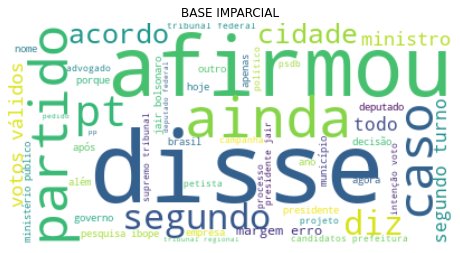

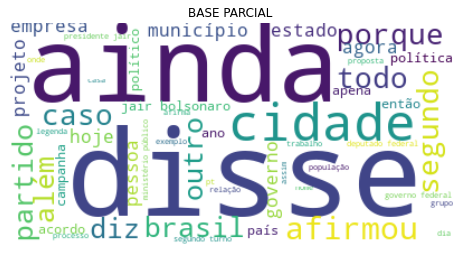

In [18]:
import matplotlib.pyplot as plt

from nltk.probability import FreqDist
from wordcloud import WordCloud

print("PALAVRAS EM DESTAQUE DA BASE")

impartial_base = training[training['typeNaive'] == 'impartial']

impartial_unique_string = impartial_base['article_tokens'].apply(lambda text : (" ").join(text) )
impartial_frequency = FreqDist( impartial_unique_string )
impartial_word_dict = impartial_frequency.keys()

impartial_unique_string = (" ").join(impartial_word_dict)

wordcloud_impartial = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=50,
    background_color="white"
).generate( impartial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE IMPARCIAL")
plt.imshow(wordcloud_impartial, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)



partial_base = training[training['typeNaive'] == 'partial']

partial_unique_string = partial_base['article_tokens'].apply(lambda text : (" ").join(text) )
partial_frequency = FreqDist( partial_unique_string )
partial_word_dict = partial_frequency.keys()

partial_unique_string = (" ").join(partial_word_dict)

wordcloud_partial = WordCloud(
    stopwords=['não'],
    margin=0,
    max_words=50,
    background_color="white"
).generate( partial_unique_string )

plt.figure(figsize=(8,6))
plt.title("BASE PARCIAL")
plt.imshow(wordcloud_partial, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
